## Making prediction function

In [2]:
import os
import joblib
import pandas as pd

def predict_new_data_chunked(input_csv, chunksize=10000):
    # Load model once
    model = joblib.load("full_xgb_model.pkl")
    
    feature_cols = [f"feat{i}" for i in range(1, 10)]
    
    # Prepare output folder
    out_folder = "predictions"
    os.makedirs(out_folder, exist_ok=True)
    
    # Prepare output file path
    base_name = os.path.splitext(os.path.basename(input_csv))[0]
    out_path = os.path.join(out_folder, f"{base_name}_prediction.csv")
    
    # Remove existing output file if exists (to overwrite fresh)
    if os.path.exists(out_path):
        os.remove(out_path)
    
    # Process input CSV in chunks
    for i, chunk in enumerate(pd.read_csv(input_csv, chunksize=chunksize)):
        # Group by transcript_id, position, kmer; aggregate feature columns by mean
        agg_funcs = {col: "mean" for col in feature_cols}
        grouped = chunk.groupby(["transcript_id", "position", "kmer"], as_index=False).agg(agg_funcs)
        
        # Extract features for prediction
        X_new_features = grouped[feature_cols]
        
        # Predict probabilities for positive class
        preds = model.predict_proba(X_new_features)[:, 1]
        
        # Create prediction DataFrame
        result = pd.DataFrame({
            "transcript_id": grouped["transcript_id"],
            "transcript_position": grouped["position"],
            "kmer": grouped["kmer"],
            "score": preds
        })
        
        # Append chunk predictions to CSV file
        if i == 0:
            result.to_csv(out_path, index=False)
        else:
            result.to_csv(out_path, mode='a', header=False, index=False)
        
        print(f"  Processed chunk {i+1} ({len(chunk)} rows)")
    
    print(f"Predictions saved to: {out_path}")

# Example to run over all CSV files in prepared_data folder:
input_folder = "prepared_data"
files = [f for f in os.listdir(input_folder) if f.endswith(".csv")]

for f in files:
    file_path = os.path.join(input_folder, f)
    print(f"🔹 Running predictions on {file_path}...")
    predict_new_data_chunked(file_path)




🔹 Running predictions on prepared_data/SGNex_MCF7_directRNA_replicate3_run1.csv...
  Processed chunk 1 (10000 rows)
  Processed chunk 2 (10000 rows)
  Processed chunk 3 (10000 rows)
  Processed chunk 4 (10000 rows)
  Processed chunk 5 (10000 rows)
  Processed chunk 6 (10000 rows)
  Processed chunk 7 (10000 rows)
  Processed chunk 8 (10000 rows)
  Processed chunk 9 (10000 rows)
  Processed chunk 10 (10000 rows)
  Processed chunk 11 (10000 rows)
  Processed chunk 12 (10000 rows)
  Processed chunk 13 (10000 rows)
  Processed chunk 14 (10000 rows)
  Processed chunk 15 (10000 rows)
  Processed chunk 16 (10000 rows)
  Processed chunk 17 (10000 rows)
  Processed chunk 18 (10000 rows)
  Processed chunk 19 (10000 rows)
  Processed chunk 20 (10000 rows)
  Processed chunk 21 (10000 rows)
  Processed chunk 22 (10000 rows)
  Processed chunk 23 (10000 rows)
  Processed chunk 24 (10000 rows)
  Processed chunk 25 (10000 rows)
  Processed chunk 26 (10000 rows)
  Processed chunk 27 (10000 rows)
  Proces

## Examine average prediction score across cell lines

In [3]:
import os
import pandas as pd
from collections import defaultdict

# Path to the predictions folder
predictions_folder = "predictions"

# Initialize dictionaries to accumulate scores for each cell line
cell_line_score_sum = defaultdict(float)
cell_line_score_count = defaultdict(int)

# List all prediction CSV files
files = [f for f in os.listdir(predictions_folder) if f.endswith(".csv")]

# Function to extract cell line name from file name
def extract_cell_line(filename):
    # Example: SGNex_A549_directRNA_replicate5_run1_prediction.csv -> A549
    parts = filename.split('_')
    return parts[1] if len(parts) > 1 else None

# Process each file in chunks
for f in files:
    file_path = os.path.join(predictions_folder, f)
    print(f"🔍 Processing {file_path}...")

    # Extract cell line
    cell_line = extract_cell_line(f)
    if not cell_line:
        print(f"⚠️ Unable to find cell line in filename: {f}")
        continue

    for chunk in pd.read_csv(file_path, chunksize=100000):  # Adjust chunk size as needed
        # Accumulate the sum and count for this cell line
        cell_line_score_sum[cell_line] += chunk["score"].sum()
        cell_line_score_count[cell_line] += len(chunk)

# Compute the average score for each cell line
cell_line_avg_scores = {cell: cell_line_score_sum[cell] / cell_line_score_count[cell]
                        for cell in cell_line_score_sum}

# Display the results
print("\n📊 Average prediction scores by cell line:")
for cell, avg in sorted(cell_line_avg_scores.items(), key=lambda x: x[0]):
    print(f"{cell}: {avg:.4f}")


🔍 Processing predictions/SGNex_HEYA8_directRNA_replicate3_run1_prediction.csv...
🔍 Processing predictions/SGNex_Hct116_directRNA_replicate3_run1_prediction.csv...
🔍 Processing predictions/SGNex_MCF7_directRNA_replicate4_run1_prediction.csv...
🔍 Processing predictions/SGNex_HEYA8_directRNA_replicate2_run2_prediction.csv...
🔍 Processing predictions/SGNex_H9_directRNA_replicate4_run2_prediction.csv...
🔍 Processing predictions/SGNex_Hct116_directRNA_replicate3_run4_prediction.csv...
🔍 Processing predictions/SGNex_K562_directRNA_replicate6_run1_prediction.csv...
🔍 Processing predictions/SGNex_MCF7_directRNA_replicate3_run1_prediction.csv...
🔍 Processing predictions/SGNex_H9_directRNA_replicate3_run1_prediction.csv...
🔍 Processing predictions/SGNex_HEYA8_directRNA_replicate1_run1_prediction.csv...
🔍 Processing predictions/SGNex_HEYA8_directRNA_replicate2_run1_prediction.csv...
🔍 Processing predictions/SGNex_HEYA8_directRNA_replicate1_run2_prediction.csv...
🔍 Processing predictions/SGNex_H9_d

In [4]:
import os
import pandas as pd
from collections import defaultdict

# Path to the predictions folder
predictions_folder = "predictions"

# Initialize dictionaries to accumulate scores for each kmer
kmer_score_sum = defaultdict(float)
kmer_score_count = defaultdict(int)

# List all prediction CSV files
files = [f for f in os.listdir(predictions_folder) if f.endswith(".csv")]

# Process each file in chunks
for f in files:
    file_path = os.path.join(predictions_folder, f)
    print(f"🔍 Processing {file_path}...")

    for chunk in pd.read_csv(file_path, usecols=["kmer", "score"], chunksize=100000):
        grouped = chunk.groupby("kmer")["score"].agg(['sum', 'count'])
        for kmer, row in grouped.iterrows():
            kmer_score_sum[kmer] += row['sum']
            kmer_score_count[kmer] += row['count']

# Compute the average score for each kmer
kmer_avg_scores = {kmer: kmer_score_sum[kmer] / kmer_score_count[kmer]
                   for kmer in kmer_score_sum}


🔍 Processing predictions/SGNex_HEYA8_directRNA_replicate3_run1_prediction.csv...
🔍 Processing predictions/SGNex_Hct116_directRNA_replicate3_run1_prediction.csv...
🔍 Processing predictions/SGNex_MCF7_directRNA_replicate4_run1_prediction.csv...
🔍 Processing predictions/SGNex_HEYA8_directRNA_replicate2_run2_prediction.csv...
🔍 Processing predictions/SGNex_H9_directRNA_replicate4_run2_prediction.csv...
🔍 Processing predictions/SGNex_Hct116_directRNA_replicate3_run4_prediction.csv...
🔍 Processing predictions/SGNex_K562_directRNA_replicate6_run1_prediction.csv...
🔍 Processing predictions/SGNex_MCF7_directRNA_replicate3_run1_prediction.csv...
🔍 Processing predictions/SGNex_H9_directRNA_replicate3_run1_prediction.csv...
🔍 Processing predictions/SGNex_HEYA8_directRNA_replicate1_run1_prediction.csv...
🔍 Processing predictions/SGNex_HEYA8_directRNA_replicate2_run1_prediction.csv...
🔍 Processing predictions/SGNex_HEYA8_directRNA_replicate1_run2_prediction.csv...
🔍 Processing predictions/SGNex_H9_d

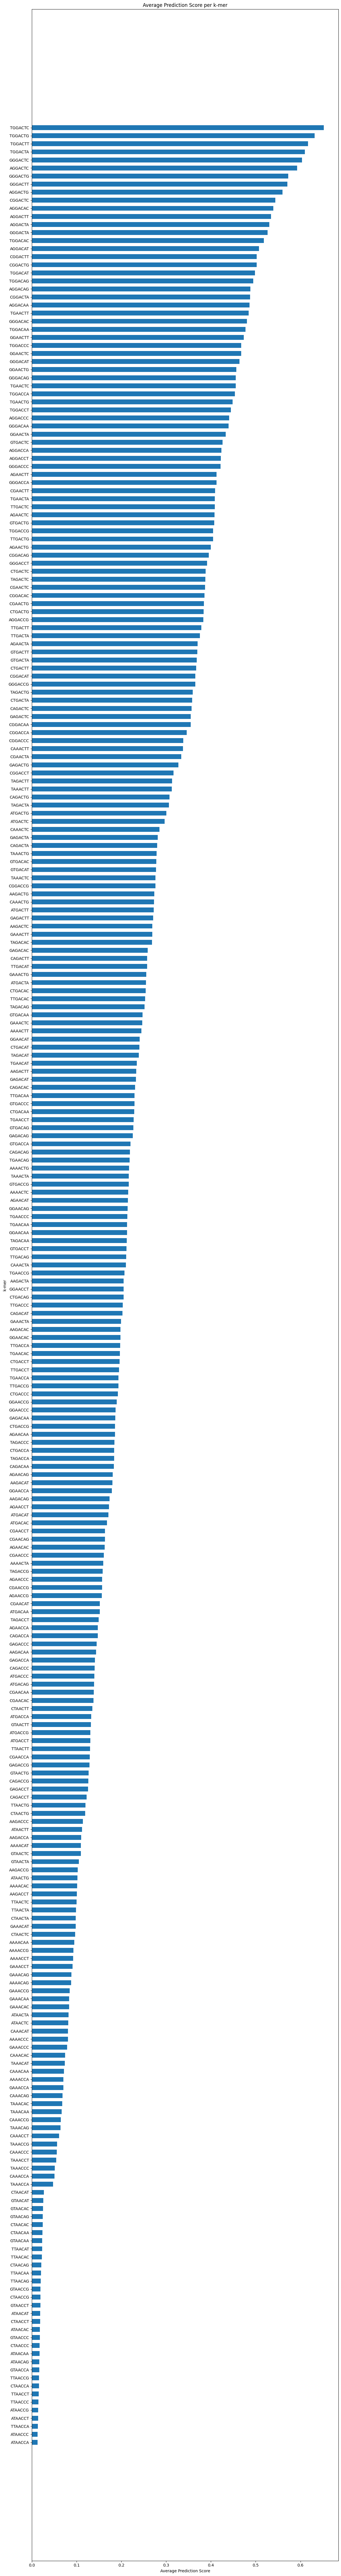

In [14]:
import matplotlib.pyplot as plt

# Suppose kmer_avg_scores is your dictionary of kmer -> avg score
# Example:
# kmer_avg_scores = {"AAAACAA": 0.23, "AAAACAC": 0.45, ...}

# Sort kmers by descending average score
sorted_kmers = sorted(kmer_avg_scores, key=kmer_avg_scores.get, reverse=True)
sorted_scores = [kmer_avg_scores[k] for k in sorted_kmers]

# Create a very tall figure to fit all 288 bars comfortably
plt.figure(figsize=(12, 90))  # width=12, height=90 inches (adjust height as needed)

# Plot horizontal bars
plt.barh(sorted_kmers, sorted_scores, height=0.6)  # height controls bar thickness

plt.xlabel("Average Prediction Score")
plt.ylabel("k-mer")
plt.title("Average Prediction Score per k-mer")
plt.gca().invert_yaxis()  # Highest scores on top

plt.tight_layout()

# Save as PDF for easy scrolling and zooming
plt.savefig("kmer_avg_scores_large_plot.pdf")

# Show the plot (optional)
plt.show()






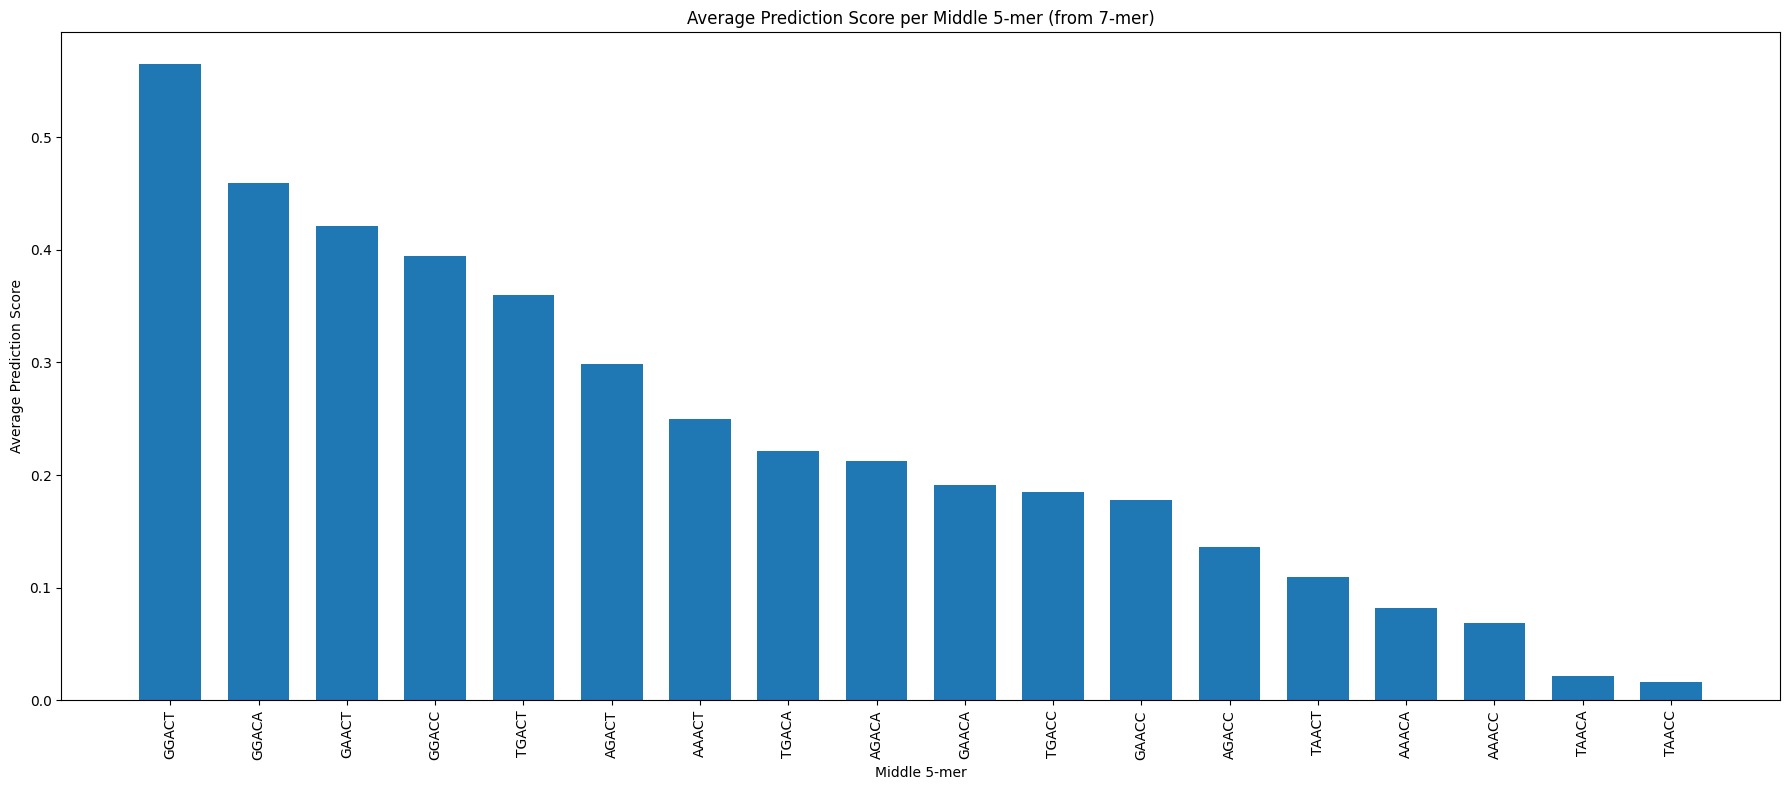

In [16]:
import matplotlib.pyplot as plt
from collections import defaultdict

# Assuming kmer_avg_scores is your dictionary of 7-mers and their average scores

# Extract middle 5-mer scores
middle_5mer_scores = defaultdict(list)

for kmer7, score in kmer_avg_scores.items():
    middle_5mer = kmer7[1:6]  # middle 5-mer substring
    middle_5mer_scores[middle_5mer].append(score)

# Calculate average score for each middle 5-mer
middle_5mer_avg_scores = {k: sum(v) / len(v) for k, v in middle_5mer_scores.items()}

# Sort by average score descending
sorted_5mers = sorted(middle_5mer_avg_scores, key=middle_5mer_avg_scores.get, reverse=True)
sorted_scores_5mer = [middle_5mer_avg_scores[k] for k in sorted_5mers]

# Plot vertical bar chart
plt.figure(figsize=(18, 8))  # wider for readability
plt.bar(sorted_5mers, sorted_scores_5mer, width=0.7)
plt.ylabel("Average Prediction Score")
plt.xlabel("Middle 5-mer")
plt.title("Average Prediction Score per Middle 5-mer (from 7-mer)")
plt.xticks(rotation=90, ha='center')  # rotate x labels for readability
plt.tight_layout()
plt.savefig("middle_5mer_avg_scores_vertical.pdf")
plt.show()



## Second key finding

In [18]:
import os

base_folder = "rna_modification_data"

no_data_cell_lines = []

# Loop through all immediate subfolders (cell lines)
for cell_line in os.listdir(base_folder):
    cell_line_path = os.path.join(base_folder, cell_line)
    if not os.path.isdir(cell_line_path):
        continue
    
    # Look for JSON files in subfolders under this cell_line folder
    has_json = False
    for root, dirs, files in os.walk(cell_line_path):
        # If any JSON file is found in any inner folder, mark True
        if any(f.endswith('.json') for f in files):
            has_json = True
            break
    
    if not has_json:
        no_data_cell_lines.append(cell_line)

print("Cell lines with no JSON data found:")
for line in no_data_cell_lines:
    print(f"- {line}")


Cell lines with no JSON data found:
- SGNex_HepG2_directRNA_replicate5_run2
- SGNex_Hct116_directRNA_replicate4_run3
- SGNex_K562_directRNA_replicate5_run1
- SGNex_HepG2_directRNA_replicate6_run1
- SGNex_K562_directRNA_replicate4_run1


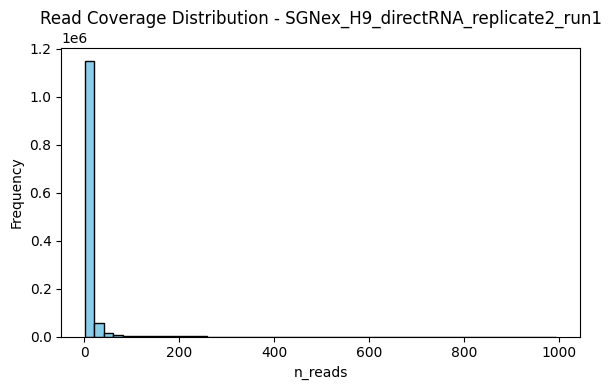

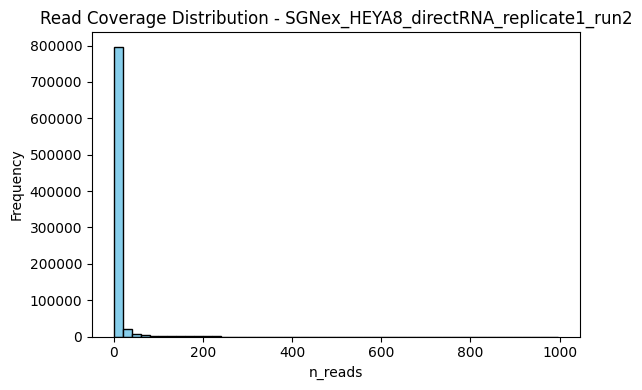

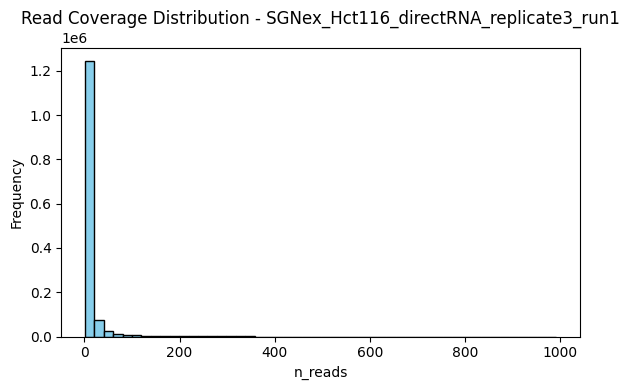

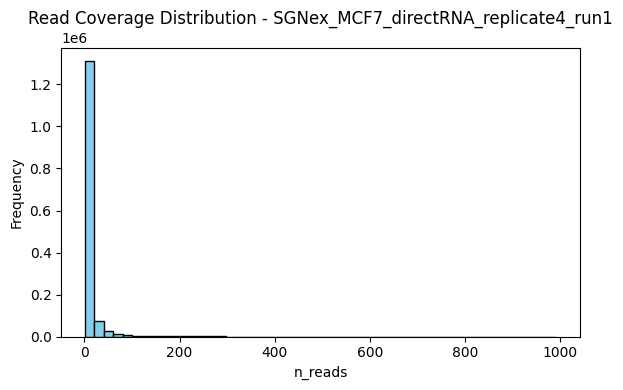

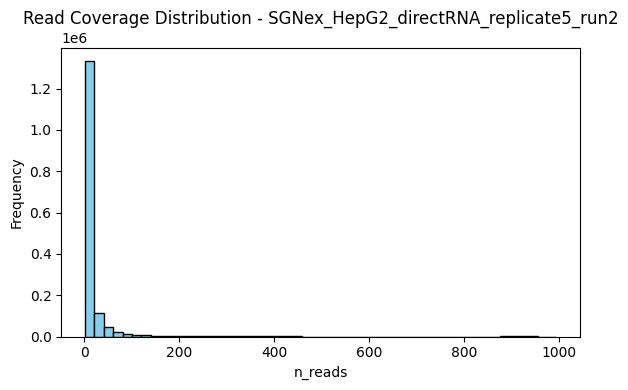

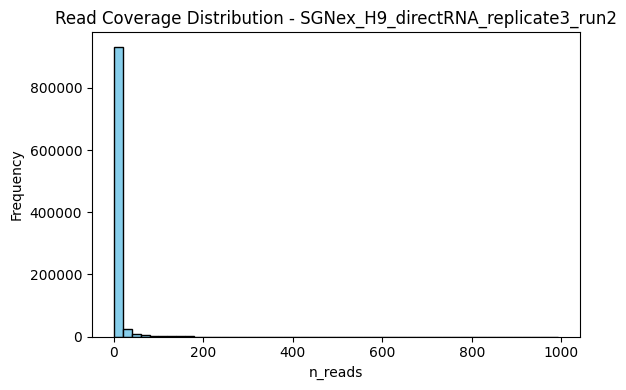

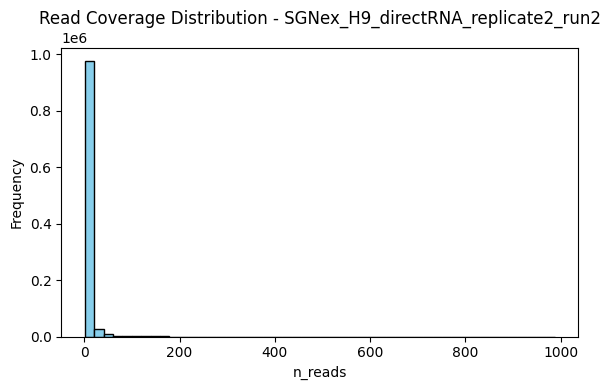

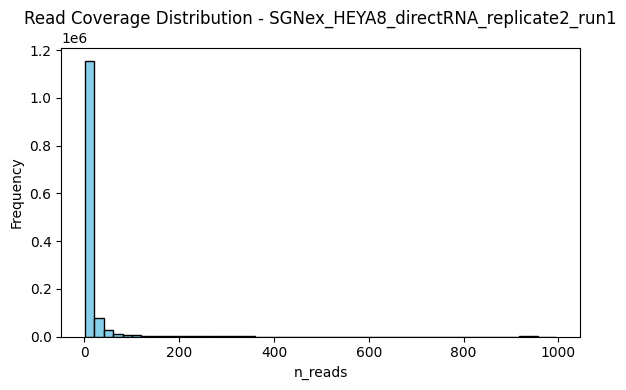

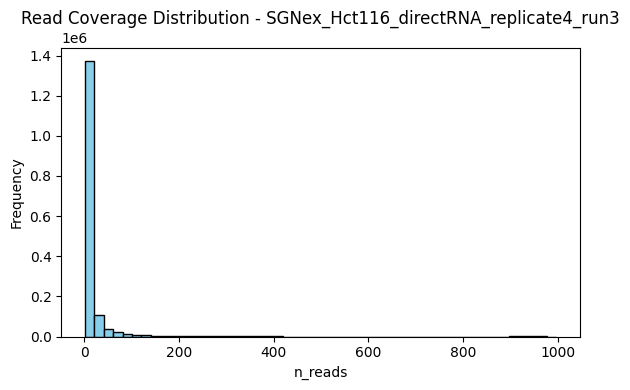

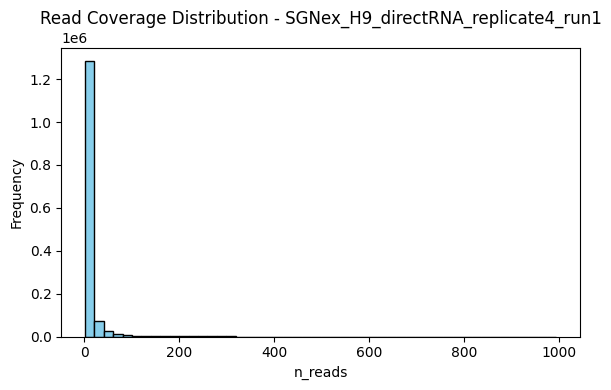

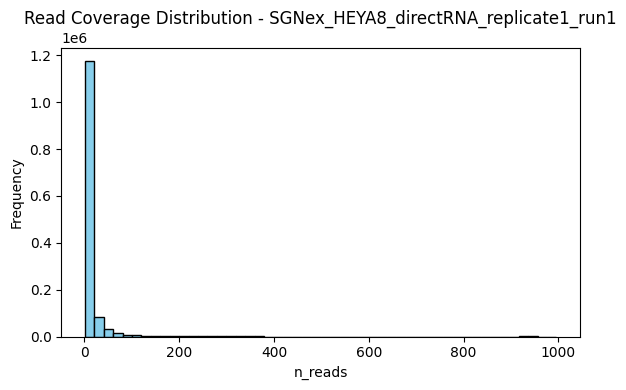

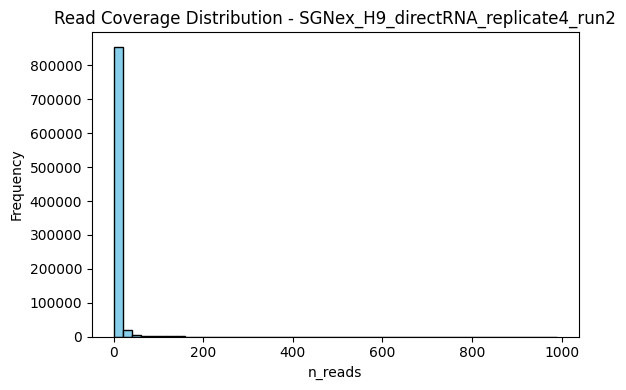

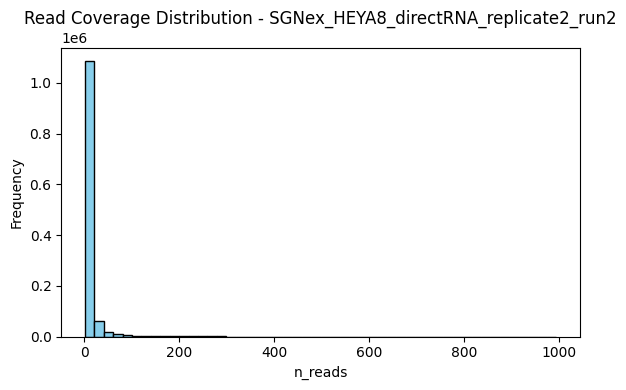

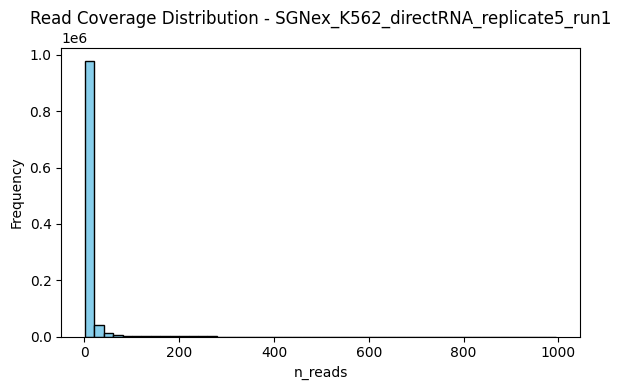

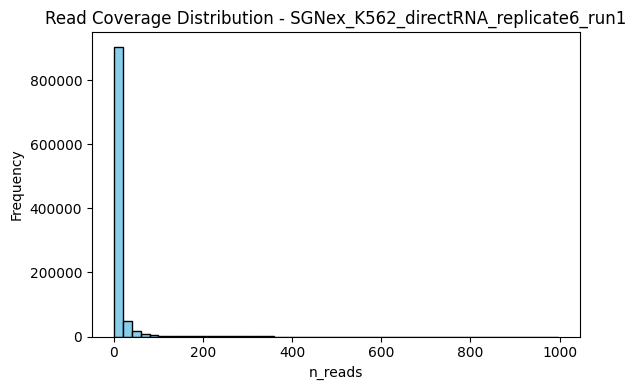

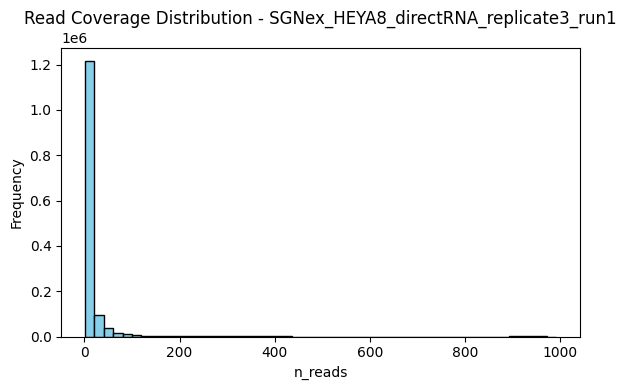

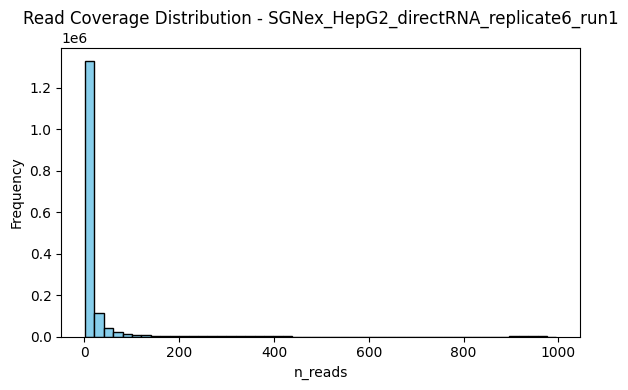

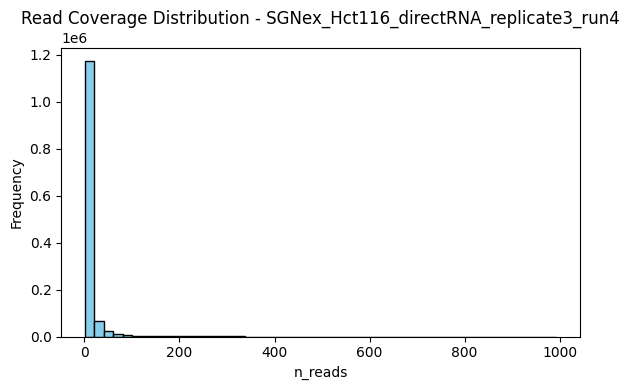

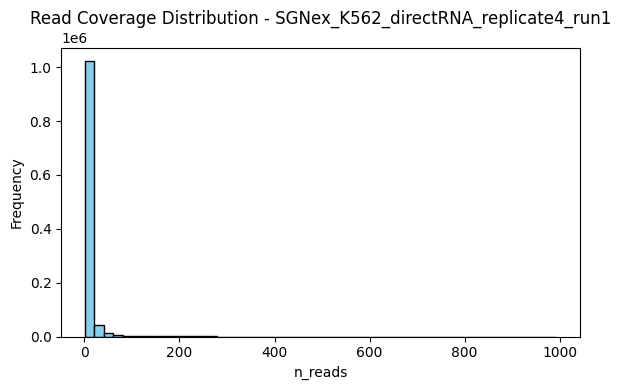

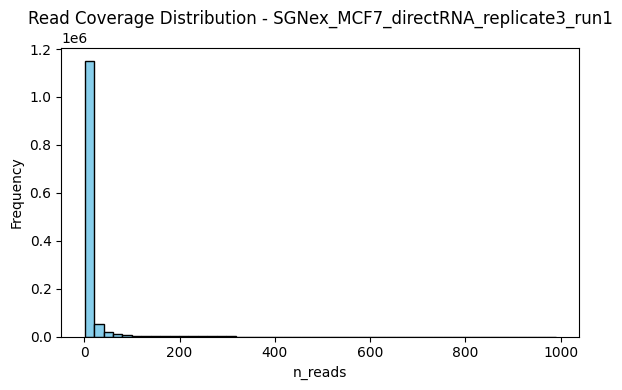

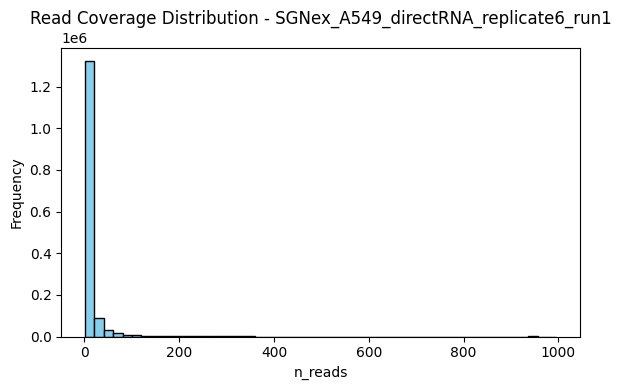

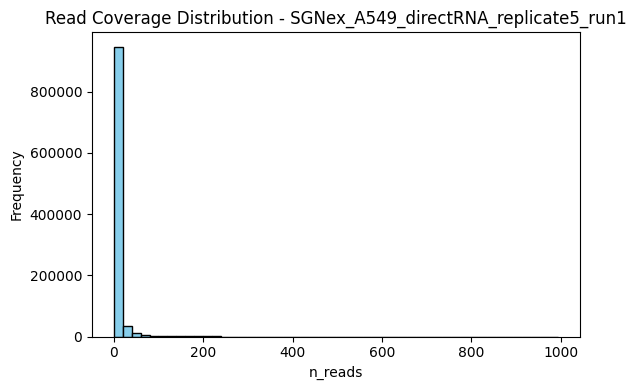

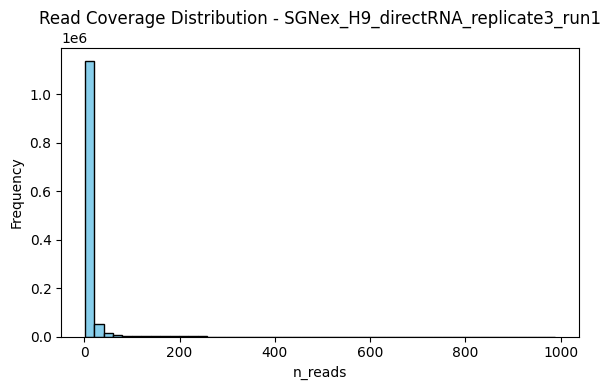

                                 cell_line  total_reads  \
0       SGNex_H9_directRNA_replicate2_run1     11630078   
1    SGNex_HEYA8_directRNA_replicate1_run2      5431441   
2   SGNex_Hct116_directRNA_replicate3_run1     16823006   
3     SGNex_MCF7_directRNA_replicate4_run1     15671886   
4    SGNex_HepG2_directRNA_replicate5_run2     27928565   
5       SGNex_H9_directRNA_replicate3_run2      5989508   
6       SGNex_H9_directRNA_replicate2_run2      6427190   
7    SGNex_HEYA8_directRNA_replicate2_run1     17133852   
8   SGNex_Hct116_directRNA_replicate4_run3     25873301   
9       SGNex_H9_directRNA_replicate4_run1     15809669   
10   SGNex_HEYA8_directRNA_replicate1_run1     18620593   
11      SGNex_H9_directRNA_replicate4_run2      4680666   
12   SGNex_HEYA8_directRNA_replicate2_run2     12913032   
13    SGNex_K562_directRNA_replicate5_run1      9673164   
14    SGNex_K562_directRNA_replicate6_run1     11781235   
15   SGNex_HEYA8_directRNA_replicate3_run1     21832996 

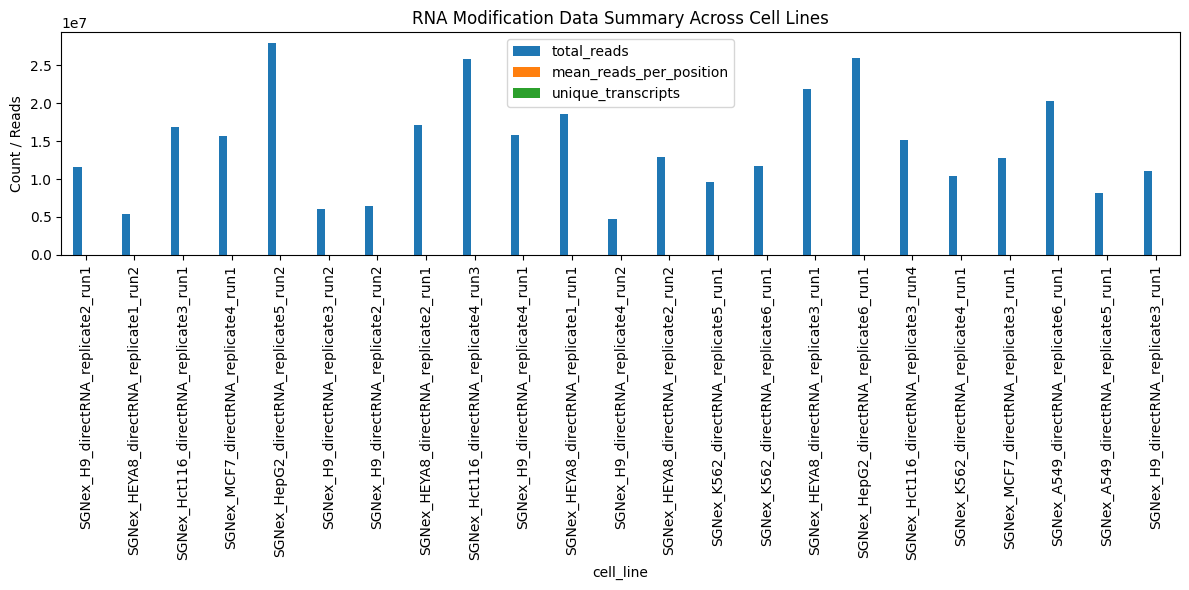

In [21]:
import os
import pandas as pd
import matplotlib.pyplot as plt

rna_data_dir = "rna_modification_data"

# Store summary info here
summary_stats = []

for folder in os.listdir(rna_data_dir):
    folder_path = os.path.join(rna_data_dir, folder)
    data_info_path = os.path.join(folder_path, "data.info")
    
    if os.path.isfile(data_info_path):
        try:
            df = pd.read_csv(data_info_path)
            
            total_reads = df['n_reads'].sum()
            mean_reads = df['n_reads'].mean()
            unique_transcripts = df['transcript_id'].nunique()
            unique_positions = df['transcript_position'].nunique()
            
            summary_stats.append({
                "cell_line": folder,
                "total_reads": total_reads,
                "mean_reads_per_position": mean_reads,
                "unique_transcripts": unique_transcripts,
                "unique_positions": unique_positions,
            })
            
            # Optional: plot distribution of n_reads for each folder
            plt.figure(figsize=(6, 4))
            plt.hist(df['n_reads'], bins=50, color='skyblue', edgecolor='black')
            plt.title(f"Read Coverage Distribution - {folder}")
            plt.xlabel("n_reads")
            plt.ylabel("Frequency")
            plt.tight_layout()
            plt.show()
            
        except Exception as e:
            print(f"Error processing {data_info_path}: {e}")
    else:
        print(f"No data.info found in {folder_path}")

# Summarize all folders
summary_df = pd.DataFrame(summary_stats)
print(summary_df)

# Plot comparisons across cell lines
summary_df.set_index('cell_line')[['total_reads', 'mean_reads_per_position', 'unique_transcripts']].plot(
    kind='bar', figsize=(12,6), title="RNA Modification Data Summary Across Cell Lines"
)
plt.ylabel("Count / Reads")
plt.tight_layout()
plt.show()
